In [511]:
# Import common libraries
import pandas as pd
import numpy as np
from copy import deepcopy
import importlib


# Import MNE processing
from mne.viz import plot_compare_evokeds
from mne import Epochs, events_from_annotations, set_log_level
from mne_nirs.visualisation import plot_glm_group_topo

# Scikit Learn
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Import StatsModels
import statsmodels.formula.api as smf

# Import Plotting Library
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from mne_nirs.statistics import run_glm
import matplotlib as mpl

# Internal Packages
import analysis_tools
import system_file_io
import quality_eval
import dynamic_interval_tools
import glm_analysis
import visualizations

# Reset the cache
importlib.reload(analysis_tools)
importlib.reload(system_file_io)
importlib.reload(dynamic_interval_tools)
importlib.reload(glm_analysis)
importlib.reload(visualizations)

<module 'visualizations' from '/Users/nolanbrady/Desktop/fNIRs-data-pipeline/python/visualizations.py'>

In [512]:
# ------------------------------------------------------------------
# Recurring values that we will allow for users to change in the GUI
# ------------------------------------------------------------------

# Length of the measured interval
interval_length = 12

# Time from trigger point being evaluated
tmin = -1
tmax = 12

# How you would like to rename the numeric triggers from Aurora
# trigger_id = None
# trigger_id = {'4': 'Control', '2': 'Neutral', '3': 'Inflam', '1':'Practice'}
trigger_id = {'1': 'Start', '2': 'Neutral', '3': 'Concern'}

# What files would you like to ignore while looping through subjects
ignore = [".DS_Store", "sub-03", ".git", ".gitignore"]

# File path to the folder containing the BIDS data.
# root_dir = '../../LabResearch/IndependentStudy/DataAnalysis/'
root_dir = '../../FV_Prelim_Data'

# Mock data folder to test pulling meta data from folder structure.
# path = "../../LabResearch/IndependentStudy/Data/BIDS-NIRS-Tapping"
# path = "../../LabResearch/IndependentStudy/Data/FA"
path = '../../FV_Prelim_Data'

# Does the study have variable task lengths or does the study follow a block design?
variable_epoch_time = False

# Specifies what columns to use for the GLM constrast. If None, contrast is skipped
# Only two columns can be specified
# columns_for_glm_contrast = ['Neutral', 'Inflam']
columns_for_glm_contrast = ['Neutral', 'Concern']

# Specifies what columns to use for group level analysis.
# columns_for_group_analysis = ['Neutral', 'Inflam']
columns_for_group_analysis = ['Neutral', 'Concern']

In [513]:

def run_group_analysis(path, ignore, variable_epoch_time, columns_for_glm_contrast, columns_for_group_analysis, tmin=None, tmax=None, trigger_id=None):
    # Establish the groups, subject names, and snirf file paths for all subjects
    groups, df = system_file_io.import_data_folder(path, ignore)
    # run the analysis for each group
    glm_dataframes = {}
    for group in groups:
        paths = df[df.eq(group).any(1)]['snirf_path'].to_numpy()

        # Processes all Epochs with proper timestamps and collects it in all_epochs
        # all_data is dict of epoch, condition, raw_haemo, raw_intensity, and f_path for all subs
        all_epochs, all_data, all_evokeds = analysis_tools.aggregate_epochs(paths=paths, trigger_id=trigger_id, variable_epoch_time = variable_epoch_time)

        # Process the GLM for all participants in the group into a list of design matrixes
        glm_data = glm_analysis.create_design_matrix(all_data, tmin, tmax)
        print("GLM Data Processed ---> Calcuating GLM Dataframe")
        print(glm_data, columns_for_glm_contrast)
        
        # Converts the glm design matrixes into a dataframe
        df_cha, df_con = glm_analysis.create_glm_df(glm_data, columns_for_glm_contrast)

        print(df_cha)
        print("GLM Dataframe Generated. Finding all significant channels")
        # Find the groups significant channels
        significant_channels = analysis_tools.find_significant_channels(df_cha)

        glm_dataframes[group] = {"channels_df": df_cha, "contrasts_df": df_con, "significant_channels": significant_channels, "all_data": all_data}
        
    return glm_dataframes, all_epochs, all_evokeds

In [514]:
def run_individual_analysis(path, ignore, variable_epoch_time, columns_for_glm_contrast, columns_for_group_analysis, tmin=None, tmax=None, trigger_id=None):
    groups, df = system_file_io.import_data_folder(path, ignore)
    # run the analysis for each group
    glm_dataframes = {}

    paths = df[df.any(1)]['snirf_path'].to_numpy()

    for id, path in enumerate(paths):
        # Processes all Epochs with proper timestamps and collects it in all_epochs
        # all_data is dict of epoch, condition, raw_haemo, raw_intensity, and f_path for all subs
        all_epochs, all_data, all_evokeds = analysis_tools.aggregate_epochs(paths=[path], trigger_id=trigger_id, variable_epoch_time = variable_epoch_time)

        # Process the GLM for all participants in the group into a list of design matrixes
        glm_data = glm_analysis.create_design_matrix(all_data, tmin, tmax)

        # Converts the glm design matrixes into a dataframe
        df_cha, df_con = glm_analysis.create_glm_df(glm_data, columns_for_glm_contrast)

        # Find the groups significant channels
        significant_channels = analysis_tools.find_significant_channels(df_cha)

        glm_dataframes[f'sub-{id+1}'] = {"channels_df": df_cha, "contrasts_df": df_con, "significant_channels": significant_channels, "all_data": all_data}
        
    return glm_dataframes, all_epochs, all_evokeds

In [515]:
importlib.reload(glm_analysis)
group_data, all_epochs, all_evokeds = run_group_analysis(path, ignore, variable_epoch_time, columns_for_glm_contrast, columns_for_group_analysis, tmin=tmin, tmax=tmax, trigger_id=trigger_id)
group_data

Loading /Users/nolanbrady/Desktop/fNIRs-data-pipeline/python/../../FV_Prelim_Data/all_groups/sub-08/nirs/2023-02-17_002.snirf
Reading 0 ... 9088  =      0.000 ...   893.350 secs...
Events [86  0  1]
Loading /Users/nolanbrady/Desktop/fNIRs-data-pipeline/python/../../FV_Prelim_Data/all_groups/sub-01/nirs/2023-02-17_002.snirf
Reading 0 ... 8713  =      0.000 ...   856.488 secs...
Events [66  0  1]
Loading /Users/nolanbrady/Desktop/fNIRs-data-pipeline/python/../../FV_Prelim_Data/all_groups/sub-06/nirs/2023-02-10_004.snirf
Reading 0 ... 9282  =      0.000 ...   912.421 secs...
Events [103   0   2]
Loading /Users/nolanbrady/Desktop/fNIRs-data-pipeline/python/../../FV_Prelim_Data/all_groups/sub-07/nirs/2023-02-17_001.snirf
Reading 0 ... 9460  =      0.000 ...   929.918 secs...
Events [110   0   1]
Loading /Users/nolanbrady/Desktop/fNIRs-data-pipeline/python/../../FV_Prelim_Data/all_groups/sub-09/nirs/2023-03-01_004.snirf
Reading 0 ... 13102  =      0.000 ...  1287.927 secs...
Events [407   0 

{'all_groups': {'channels_df': variable Condition    df           mse   p_value            se         t  \
0          Concern  21.0  4.126853e-12  0.178745  6.263993e-07  1.391148   
1          Neutral  21.0  4.126853e-12  0.738956  6.273092e-07  0.337680   
2            Start  21.0  4.126853e-12  0.655185  2.149083e-06  0.453013   
3         constant  21.0  4.126853e-12  0.689450  4.733191e-07 -0.405171   
4          drift_1  21.0  4.126853e-12  0.992607  1.194597e-05 -0.009377   
...            ...   ...           ...       ...           ...       ...   
19327      drift_5  21.0  1.377884e-12  0.828446  1.010108e-05 -0.219414   
19328      drift_6  21.0  1.377884e-12  0.949157  9.977163e-06  0.064532   
19329      drift_7  21.0  1.377884e-12  0.977449  9.903960e-06 -0.028606   
19330      drift_8  21.0  1.377884e-12  0.833963  9.831958e-06  0.212244   
19331      drift_9  21.0  1.377884e-12  0.847722  9.771250e-06  0.194412   

variable         theta Source Detector Chroma  Significa

In [516]:
# individual_data, all_epochs, all_evokeds = run_individual_analysis(path, ignore, variable_epoch_time, columns_for_glm_contrast, columns_for_group_analysis, trigger_id)
# individual_data

# Visualizations

GROUP:  all_groups


/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


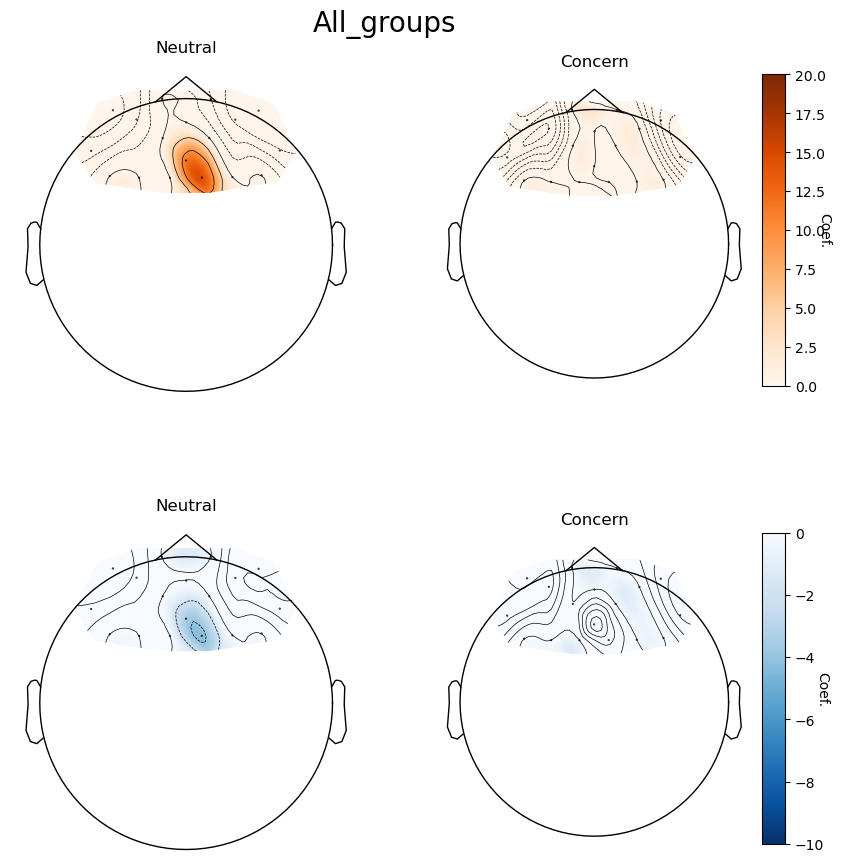

In [517]:
# Group Visualization
importlib.reload(visualizations)
groups = list(group_data.keys())
for group in groups:
    # channels_df, contrasts_df, significant_channels, all_data = group_data['direct'].values()
    channels_df, contrasts_df, significant_channels, all_data = group_data[group].values()

    raw_haemo = all_data[0]['raw_haemo']
    visualizations.group_topological_visualisation(channels_df, columns_for_glm_contrast, raw_haemo, group)

Concern 8
combining channels using "mean"
Neutral 8
combining channels using "mean"
Start 8
combining channels using "mean"
Concern 8
combining channels using "mean"
Neutral 8
combining channels using "mean"
Start 8
combining channels using "mean"


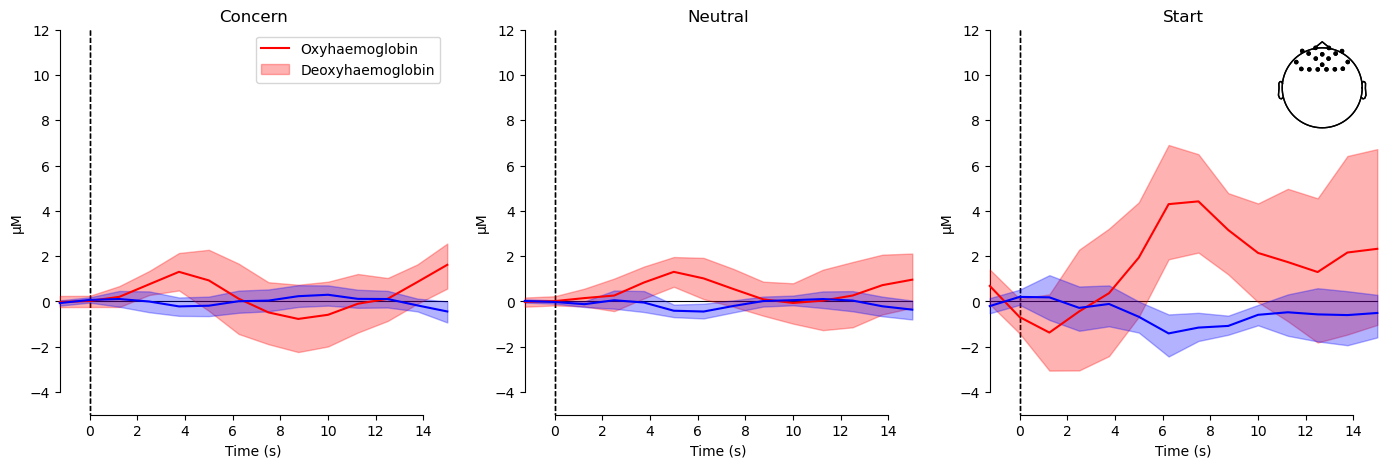

In [518]:
importlib.reload(visualizations)
visualizations.plot_waveform_analysis(all_evokeds, variable_epoch_time)

In [535]:
# Individual Visualization
# importlib.reload(visualizations)
# if individual_data:
#     channels_df, contrasts_df, significant_channels, all_data = individual_data['sub-1'].values()

#     raw_haemo = all_data[0]['raw_haemo']

#     visualizations.group_topological_visualisation(channels_df, columns_for_glm_contrast, raw_haemo)

# Statistical Summary

In [519]:
# Generate a summarized dataframe of the channels and conditions significance
importlib.reload(analysis_tools)

ch_model_df = analysis_tools.create_results_dataframe(channels_df, columns_for_glm_contrast, raw_haemo)


/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [533]:
importlib.reload(analysis_tools)
sig_cha = analysis_tools.find_significant_channels(ch_model_df, adjust_coef=True)
sig_cha

/Users/nolanbrady/Desktop/fNIRs-data-pipeline/python/analysis_tools.py:288: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_sig_channels = all_sig_channels.append(sig_df)
/Users/nolanbrady/Desktop/fNIRs-data-pipeline/python/analysis_tools.py:289: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  
/Users/nolanbrady/Desktop/fNIRs-data-pipeline/python/analysis_tools.py:288: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_s

Coef. Std.Err.         z     P>|z|    [0.025  \
ch_name   Condition                                                     
S2_D1 hbo Concern   -14.062955      0.0 -2.883885  0.003928 -0.000002   
          Neutral   -11.985006      0.0 -2.457761  0.013981 -0.000002   
S2_D3 hbo Concern    -9.964516      0.0 -2.043419  0.041011 -0.000002   
          Neutral   -16.945442      0.0 -3.474995  0.000511 -0.000003   
S3_D3 hbo Concern   -15.162544      0.0 -3.109377  0.001875 -0.000002   
          Neutral   -10.595603      0.0 -2.172836  0.029793 -0.000002   
S4_D4 hbo Neutral    11.654932      0.0  2.390072  0.016845       0.0   
S4_D5 hbo Neutral    14.651713      0.0  3.004621  0.002659  0.000001   
S5_D6 hbo Neutral    -9.782750      0.0 -2.006145  0.044841 -0.000002   
S6_D6 hbo Neutral   -15.923072      0.0 -3.265338  0.001093 -0.000003   
S8_D6 hbo Concern   -12.276171      0.0 -2.517470  0.011820 -0.000002   
          Neutral   -18.228035      0.0 -3.738016  0.000185 -0.000003   
S8_D7 hbo Concern   -14.573010      0.0 -2.988482  0.002804 -0.000002   
          Neutral   -14.566007      0.0 -2.987045  0.002817 -0.000002   
S2_D1 hbr Concern     5.069335      0.0  2.912735  0.003583       0.0   
          Neutral     3.557561      0.0  2.044101  0.040944       0.0   
S2_D3 hbr Concern     3.724121      0.0  2.139803  0.032371       0.0   
          Neutral     5.510474      0.0  3.166205  0.001544       0.0   
S3_D3 hbr Concern     5.210242      0.0  2.993698  0.002756       0.0   
          Neutral     3.511231      0.0  2.017481  0.043645       0.0   
S4_D4 hbr Concern     6.773410      0.0  3.891862  0.000099       0.0   
          Neutral    -3.473659      0.0 -1.995893  0.045946 -0.000001   
S4_D5 hbr Concern     3.540675      0.0  2.034399  0.041911       0.0   
          Neutral    -4.324967      0.0 -2.485037  0.012954 -0.000001   
S6_D6 hbr Neutral     5.419749      0.0  3.114076  0.001845       0.0   
S8_D6 hbr Concern     3.746900      0.0  2.152892  0.031327       0.0   
          Neutral     5.771105      0.0  3.315958  0.000913       0.0   
S8_D7 hbr Concern     4.662313      0.0  2.678869  0.007387       0.0   
          Neutral     5.168546      0.0  2.969740  0.002981       0.0   

                       0.975] Chroma  Significant  
ch_name   Condition                                
S2_D1 hbo Concern        -0.0    hbo         True  
          Neutral        -0.0    hbo         True  
S2_D3 hbo Concern        -0.0    hbo         True  
          Neutral   -0.000001    hbo         True  
S3_D3 hbo Concern   -0.000001    hbo         True  
          Neutral        -0.0    hbo         True  
S4_D4 hbo Neutral    0.000002    hbo         True  
S4_D5 hbo Neutral    0.000002    hbo         True  
S5_D6 hbo Neutral        -0.0    hbo         True  
S6_D6 hbo Neutral   -0.000001    hbo         True  
S8_D6 hbo Concern        -0.0    hbo         True  
          Neutral   -0.000001    hbo         True  
S8_D7 hbo Concern   -0.000001    hbo         True  
          Neutral   -0.000001    hbo         True  
S2_D1 hbr Concern    0.000001    hbr         True  
          Neutral    0.000001    hbr         True  
S2_D3 hbr Concern    0.000001    hbr         True  
          Neutral    0.000001    hbr         True  
S3_D3 hbr Concern    0.000001    hbr         True  
          Neutral    0.000001    hbr         True  
S4_D4 hbr Concern    0.000001    hbr         True  
          Neutral        -0.0    hbr         True  
S4_D5 hbr Concern    0.000001    hbr         True  
          Neutral        -0.0    hbr         True  
S6_D6 hbr Neutral    0.000001    hbr         True  
S8_D6 hbr Concern    0.000001    hbr         True  
          Neutral    0.000001    hbr         True  
S8_D7 hbr Concern    0.000001    hbr         True  
          Neutral    0.000001    hbr         True

In [536]:
# Download the Results
sig_cha.to_csv('significant_channels.csv')